# Imports & Globals

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from yaml import safe_load 
from typing import Literal

In [2]:
%matplotlib inline

In [3]:
import tensorflow as tf
print("tf.version: ", tf.version.VERSION)
print("tf.keras.version: ", tf.keras.__version__)
print("tf.config.devices: ", tf.config.list_physical_devices())

tf.version:  2.9.1
tf.keras.version:  2.9.0
tf.config.devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-08-31 20:11:47.407665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 20:11:47.431340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 20:11:47.431494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# tf.compat.v1.enable_eager_execution()
# tf.compat.v1.disable_eager_execution()
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()

In [5]:
# # Check that GPU is available: cf. https://colab.research.google.com/notebooks/gpu.ipynb
assert(tf.test.gpu_device_name())

tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True) # Enable XLA.

2022-08-31 20:11:47.453094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-31 20:11:47.453697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 20:11:47.453939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 20:11:47.454098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [6]:
tf.executing_eagerly()

True

In [7]:
with open('LSTM65.yaml', 'r') as file:
    model_config = safe_load(file)

In [8]:
#Maximum sequence length including padding
global MAXLEN
MAXLEN = model_config['MAXLEN']

# Load data from csv

In [9]:
if "x1TrainRnnS" not in locals():
    train = pd.read_pickle("../data/proccesed_train_set.pkl")
    x1TrainRnnS, x2TrainRnnS = train[["x1", "x2"]].applymap(lambda x: np.asarray(x).astype('float32')).values.T
    yTrainRnnS = train["y"].astype('float32')
    print(train["y"].value_counts(ascending=True))
    del train
        
    test = pd.read_pickle("../data/proccesed_test_set.pkl")
    x1ValRnnS, x2ValRnnS = test[["x1", "x2"]].applymap(lambda x: np.asarray(x).astype('float32')).values.T
    yValRnnS = test["y"].astype('float32')
    print(test["y"].value_counts(ascending=True))
    del test

1    32499
0    38883
Name: y, dtype: int64
1    8021
0    9825
Name: y, dtype: int64


In [10]:
# del x1TrainRnnS

--------------------------------

In [11]:
# vectors = [[[1.0,2.0,3.0], [1.0,2.0,3.0]] , [[3.0,4.0,5.0],[3.0,4.0,5.0]]]

In [12]:
class CosineSimilarity(tf.keras.layers.Layer):
    '''Cosine similarity to be calculated as sum(x*y)/(sqrt(sum(x))*sqrt(sum(y))).
    This is achieved through Tensorflow functions to retain performance.
    
    Parameters
    ----------
    vects: tf.TensorArray
    
    Returns
    -------
    cosine_similarity: tf.TensorArray
       The result of the cosine similarity between the vectors.    
    '''
    __name__ = 'CosineSimilarity'
    def __init__(self, **kwargs):
        super(CosineSimilarity, self).__init__()
       
    @tf.function  # The decorator converts `cosine_similarity` into a tensolflow `Function`.
    def call(self, vects: tf.TensorArray) -> tf.TensorArray:
        x, y = vects
        return tf.math.divide(tf.reduce_sum(tf.multiply(x,y), axis=1, keepdims=True), tf.multiply(tf.norm(x, ord=2, axis=1, keepdims=True), tf.norm(y, ord=2, axis=1, keepdims=True)))

    def get_config(self):
        return super(CosineSimilarity, self).get_config()
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [13]:
# cosine_similarity = CosineSimilarity()
# cosine_similarity.call(vectors)

In [14]:
class CosineDistance(tf.keras.layers.Layer):
    '''Cosine distance to be calculated as 1-(cosine similarity).
    Where cosine similarity equals sum(x*y)/(sqrt(sum(x))*sqrt(sum(y))).
    This is achieved through Tensorflow functions to retain performance.
    
    Parameters
    ----------
    vects: tf.TensorArray
        
    
    Returns
    -------
    cosine_distance: tf.TensorArray
        The result of 1-cosine similarity between the vectors. 
    '''
    __name__ = 'CosineDistance'
    def __init__(self, **kwargs):
        super(CosineDistance, self).__init__()
       
    @tf.function  # The decorator converts `cosine_distance` into a tensorflow `Function`.
    def call(self, vects: tf.TensorArray) -> tf.TensorArray:
        x, y = vects
        return  tf.math.subtract(tf.constant([1.0]), tf.math.divide(tf.reduce_sum(tf.multiply(x,y), axis=1, keepdims=True), tf.multiply(tf.norm(x, ord=2, axis=1, keepdims=True), tf.norm(y, ord=2, axis=1, keepdims=True))))

    def get_config(self):
        return super(CosineDistance, self).get_config()
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [15]:
# cosine_distance = CosineDistance()
# cosine_distance.call(vectors)

In [16]:
# 1 - 0.9827076 = 0.017292399999999986

In [17]:
class ContrastiveLoss(tf.keras.losses.Loss):
    '''Returns a value between 0 and 1 representing the average error of the y_pred vector by comparing it to the y_true.
    '''
    __name__ = 'ContrastiveLoss'
    def __init__(self, margin: tf.float32 = 1.0, **kwargs):
        super(ContrastiveLoss, self).__init__()
        self.margin = tf.constant(margin)
        
    @tf.function # The decorator converts `loss` into a tensolflow `Function`.
    def call(self, y_true: tf.TensorArray, y_pred: tf.TensorArray) -> tf.Tensor:
        return tf.math.reduce_mean((1 - y_true) * tf.math.square(y_pred) + (y_true) * tf.math.square(tf.math.maximum(self.margin - (y_pred), 0.0)), axis = -1)
    
    def get_config(self):
        config = super(ContrastiveLoss, self).get_config()
        config.update({
            "margin": str(self.margin)
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [18]:
# a = ContrastiveLoss(margin = 1.0)
# print(a.get_config())
# tf.assert_ a.call(np.array([1,0,1]), np.array([1,0,1])).numpy() == 0.0
# tf.assert_ a.call(np.array([0,0,0]), np.array([1,0,1])).numpy() >= 0.666
# tf.assert_ a.call(np.array([0,1,0]), np.array([1,0,1])).numpy() >= 1.0

In [19]:
def get_model(model_type: Literal["lstm", "gru"], embedding_dim: int, num_rnn_node: int, num_dense_node: int, num_layer: int, activation_fn: str, learning_rate: float, optimizer_fn: Literal["Adam", "RMSprop", "SGD"], margin: float, output_activation: str) -> tf.keras.Model: 
    '''Specifies the architecture of the model to be trained.
    '''
    input_x = tf.keras.layers.Input(MAXLEN)
    input_1 = tf.keras.layers.Input(MAXLEN)
    input_2 = tf.keras.layers.Input(MAXLEN)
    embedding = tf.keras.layers.Embedding(input_dim=28, output_dim=embedding_dim, mask_zero=True)
    x = embedding(input_x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    initializer = tf.keras.initializers.GlorotUniform()
    
    match model_type:
        case "lstm":
            x = tf.keras.layers.LSTM(num_rnn_node, kernel_initializer= initializer)(x)
        case "gru":
            x = tf.keras.layers.GRU(num_rnn_node, kernel_initializer= initializer)(x)
        case "rnn":
            x = tf.keras.layers.SimpleRNN(num_rnn_node, kernel_initializer= initializer)(x)
            
    num = num_dense_node
    for _ in range(num_layer):
        x = tf.keras.layers.Dense(num, kernel_initializer = initializer, activation=activation_fn)(x)
        num /= 2
        
    embedding_network = tf.keras.Model(input_x, x)

    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)

#     cosine_similarity = CosineSimilarity()
#     merge_layer = tf.keras.layers.Lambda(cosine_similarity)([tower_1, tower_2])
    cosine_distance = CosineDistance()
    merge_layer = tf.keras.layers.Lambda(cosine_distance)([tower_1, tower_2])
    normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
    output_layer = tf.keras.layers.Dense(1, activation="hard_sigmoid")(normal_layer)
    contr = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)
    
    match optimizer_fn:
        case "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        case "RMSprop":                
            opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        case "SGD":                
            opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    contr.compile(loss=ContrastiveLoss(margin = margin), optimizer=opt, metrics=["accuracy"])
    
    return contr

In [20]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()

# Build model, load weights and evaluate on test data

In [21]:
learning_rate = model_config['Learning_Rate']

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = learning_rate,
    decay_steps=1500,
    decay_rate=0.65,
    staircase=True
)

model = get_model(
    model_type =  model_config['Model_Type'], 
    embedding_dim = model_config['Embedding_Dimensions'], 
    num_rnn_node =  model_config['Number_RNN_Nodes'],
    num_dense_node =  model_config['Number_Dense_Nodes'], 
    num_layer =  model_config['Number_Layers'], 
    activation_fn =  model_config['Activation_Function'],
    learning_rate = lr_schedule,
    optimizer_fn = model_config['Optimizer'],
    margin =  model_config['Margin'],
    output_activation = model_config['Output_Activation']
)
model.summary()

2022-08-31 20:11:48.985557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 20:11:48.985762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 20:11:48.985874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 20:11:48.986014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 20:11:48.986124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 model (Functional)             (None, 100)          54820       ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

In [22]:
EPOCHS = 200
time = datetime.datetime.now()
checkpoint_filepath = "../ModelCheckpointSaves/maxlen-{}/{}/{}/{}".format(MAXLEN,model_config["Model_Name"],time.strftime("%a-%b-%d-%Y"), time.strftime("%I-%M%p"))
print(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=15, min_delta = 0.00005, restore_best_weights = True)

../ModelCheckpointSaves/maxlen-65/BEST_LSTM65/Wed-Aug-31-2022/08-11PM


In [23]:
# Model weights are saved at the end of every epoch, if it's the best seen so far.
history = model.fit(
    x=[np.stack(x1TrainRnnS), np.stack(x2TrainRnnS)],
    y=np.stack(yTrainRnnS),
    epochs=EPOCHS,
    batch_size=800,
    shuffle=True,
    validation_data=([np.stack(x1ValRnnS), np.stack(x2ValRnnS)], np.stack(yValRnnS)),
    callbacks=[model_checkpoint_callback, early_stopping],
    use_multiprocessing=True
)

Epoch 1/200


2022-08-31 20:11:50.607024: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).
2022-08-31 20:11:54.634758: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f57b0004790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-08-31 20:11:54.634780: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2022-08-31 20:11:54.639837: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR cras

90/90 [==============================] - 10s 39ms/step - loss: 0.1508 - accuracy: 0.7887 - val_loss: 0.2533 - val_accuracy: 0.5505
Epoch 2/200
90/90 [==============================] - 3s 32ms/step - loss: 0.1010 - accuracy: 0.8798 - val_loss: 0.2914 - val_accuracy: 0.5505
Epoch 3/200
90/90 [==============================] - 1s 15ms/step - loss: 0.0764 - accuracy: 0.9139 - val_loss: 0.2473 - val_accuracy: 0.5711
Epoch 4/200
90/90 [==============================] - 1s 15ms/step - loss: 0.0610 - accuracy: 0.9337 - val_loss: 0.0878 - val_accuracy: 0.8925
Epoch 5/200
90/90 [==============================] - 1s 15ms/step - loss: 0.0501 - accuracy: 0.9463 - val_loss: 0.0637 - val_accuracy: 0.9269
Epoch 6/200
90/90 [==============================] - 1s 15ms/step - loss: 0.0430 - accuracy: 0.9536 - val_loss: 0.0558 - val_accuracy: 0.9363
Epoch 7/200
90/90 [==============================] - 1s 15ms/step - loss: 0.0364 - accuracy: 0.9616 - val_loss: 0.0486 - val_accuracy: 0.9451
Epoch 8/200
90/90

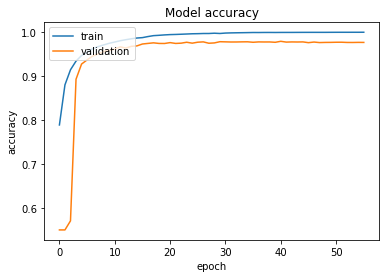

In [24]:
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

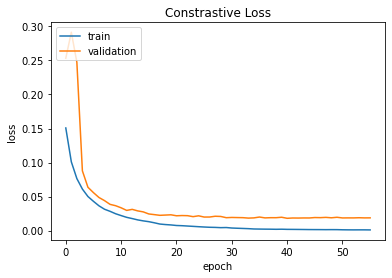

In [25]:
# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [27]:
save = input("Want to replace best model with this model? (y/n): ")

if save.lower() == "y":
    tf.keras.models.save_model(model, './saved_models/{}'.format(model_config["Model_Name"]))

Want to replace best model with this model? (y/n): y


INFO:tensorflow:Assets written to: ./saved_models/BEST_LSTM65/assets


INFO:tensorflow:Assets written to: ./saved_models/BEST_LSTM65/assets
